# Image Captioning
---

This notebook covers model inference: to apply the trained model to generate captions for images in the test dataset.
Contents:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Because data augmentation is supposed to be used only during the training step, a new set of transforms should be defined for the test dataset. More over, they should be in a correspondence with the transform used to pre-process the training images (in **2_Training.ipynb**).  For instance, image normalization.

In [10]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# Transform to pre-process the testing images.
transform_test = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.CenterCrop(224),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Test image example before pre-processing

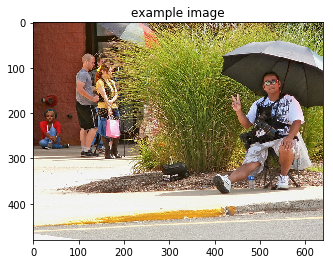

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In [12]:
# Define a `device` that is used to move PyTorch tensors to GPU (if CUDA is available)
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# Saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (word_embeddings): Embedding(8099, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=8099, bias=True)
)

<a id='step3'></a>
## Step 3: Sampler

`DecoderRNN` class from **model.py** has a `sample` method which accepts an input as a PyTorch tensor `features` containing the embedded input features corresponding to a single image. It  returns an output as a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

In [14]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

example output: [0, 3, 91, 224, 39, 3, 132, 21, 3, 370, 77, 32, 297, 18, 1, 1, 1, 1, 1, 18]


<a id='step4'></a>
## Step 4: Clean up the Captions

A `clean_sentence` function takes a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [17]:
import re
def clean_sentence(output):
    start_index = 1+output.index(0) if 0 in output else 0
    end_index = output.index(1) if 1 in output else len(output)
        
    if (end_index > (start_index+1)):
        sentence = [data_loader.dataset.vocab.idx2word[x] for x in output[start_index:end_index]]
        sentence = " ".join(sentence)
        return re.sub(r'\s([?.!"](?:\s|$))', r'\1', sentence)
    else:
        return("")

Below is an example of how `clean_sentence` function can be used.

In [18]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

example sentence: a woman sitting on a bench with a dog in the background.


<a id='step5'></a>
## Step 5: Generate Predictions!

A function (`get_prediction`) loops over images in the test dataset and prints the model's predicted caption and the image itself.

In [19]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

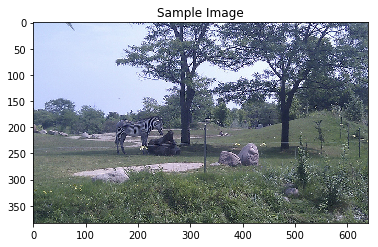

a zebra standing in a field next to a tree.


In [102]:
get_prediction()

### The model performed well!

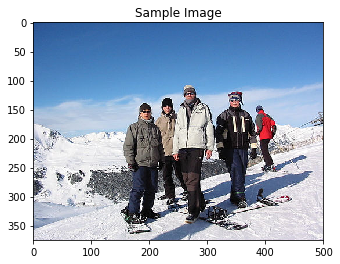

a group of people standing on top of a snow covered slope.


In [21]:
get_prediction()

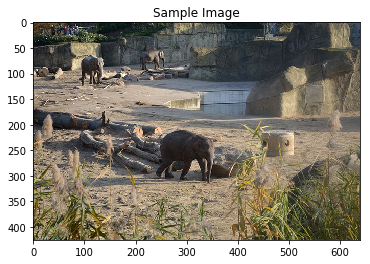

a group of elephants walking in the wild.


In [27]:
get_prediction()

### The model could have performed better ...

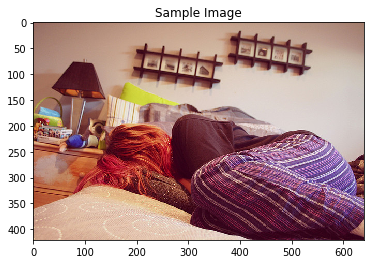

a woman laying on a bed with a cat.


In [29]:
get_prediction()

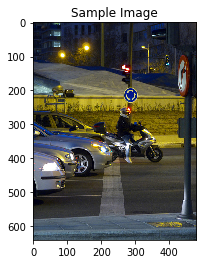

a red and white bus is parked on the side of the street.


In [30]:
get_prediction()